In [19]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Introduction

The following code was run on AWS instance. Due to time / budget constraint, I took 1% sample (initially tried 10%, but too slow to do anything) of the whole dataset which is a 4g csv file with over 37 million rows and 24 columns, completed null value imputation, feature selection, model selection and optimization on the sample dataset and was planning to use the optimized model to fit the whole dataset and make prediction. However, my best model (XGBoost) took 1 hour to finish one time training on the 1% sample (actually 60% of the 1% sample due to train-test-split). So I did not fit the model on the whole dataset eventually.

# Load the data

In [2]:
# Load less columns to save time
# The columns dropped are date_time, site_name, posa_continent, user_id
df = pd.read_csv('train.csv', usecols= [i for i in range(24) if i not in [0,1,2,7]])

In [3]:
df.dtypes

user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

In [4]:
# Check the null values. The orig_destination_distance has many missing values, 
# and by intuition I believe this feature will be important in predicting hotel type
# (people travel further may have more budget so that choose better hotels)
df.isnull().sum()

user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
is_mobile                           0
is_package                          0
channel                             0
srch_ci                         47083
srch_co                         47084
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: int64

In [5]:
# Take a 1% sample from the whole dataset 
df_sample = df.sample(frac=0.01, random_state=10)

# Missing value imputation

In [6]:
# Slice the dataset without missing value to build the model
missing = df_sample[np.isnan(df_sample.orig_destination_distance)==False]

In [7]:
# choose the features that are relevant to distance between origin and destination
X_imp = missing[['user_location_country', 'user_location_region', 'user_location_city', 
           'srch_destination_id', 'srch_destination_type_id', 
           'hotel_continent', 'hotel_country', 'hotel_market']]
y_imp = missing.orig_destination_distance

X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.4, random_state=7)

In [8]:
# Build random forest regressor and check the r2 score on test set.
# Cross validation is too computationally expensive. Due to time / budget constraint, I didn't use it in this project.
rfr = RandomForestRegressor(n_jobs=-1)
rfr.fit(X_train, y_train)
print rfr.score(X_test, y_test)

0.984618871892


In [9]:
# Check the feature importances
feature_importances = pd.DataFrame(rfr.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances

,importance
hotel_continent,0.509589
user_location_country,0.218200
user_location_region,0.145853
hotel_market,0.077827
hotel_country,0.023253
srch_destination_id,0.017475
user_location_city,0.006938
srch_destination_type_id,0.000865


In [10]:
# Drop features with importance less than 0.01 and check the r2 score again. Better
X_imp = missing[['user_location_country', 'user_location_region', 
           'srch_destination_id', 'hotel_continent', 'hotel_country', 'hotel_market']]

X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.4, random_state=7)

rfr.fit(X_train, y_train)
print rfr.score(X_test, y_test)

0.987922094998


In [11]:
# Impute missing values in the whole dataset
X_all = df[['user_location_country', 'user_location_region', 
           'srch_destination_id', 'hotel_continent', 'hotel_country', 'hotel_market']]
y_all = df.orig_destination_distance

In [12]:
# Fit the whole non missing dataset to better train the model
rfr.fit(X_imp, y_imp)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
# make prediction
dis_pred = rfr.predict(X_all)

In [14]:
# Append predicted values to the whole dataset
df['distance'] = pd.Series(dis_pred)

In [15]:
# Fill the null
df.orig_destination_distance.fillna(value=df.distance, inplace=True)

# Data cleaning

In [16]:
df.head()

,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,...,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,distance
0,66,348,48862,2234.2641,0,1,9,2014-08-27,2014-08-31,2,...,1,8250,1,0,3,2,50,628,1,2225.481552
1,66,348,48862,2234.2641,0,1,9,2014-08-29,2014-09-02,2,...,1,8250,1,1,1,2,50,628,1,2225.481552
2,66,348,48862,2234.2641,0,0,9,2014-08-29,2014-09-02,2,...,1,8250,1,0,1,2,50,628,1,2225.481552
3,66,442,35390,913.1932,0,0,3,2014-11-23,2014-11-28,2,...,1,14984,1,0,1,2,50,1457,80,1039.607260
4,66,442,35390,913.6259,0,0,3,2014-11-23,2014-11-28,2,...,1,14984,1,0,1,2,50,1457,21,1039.607260


In [17]:
df.isnull().sum()

user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance        0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                      47083
srch_co                      47084
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
distance                         0
dtype: int64

In [18]:
# 4.7k missing values compared to over 37 million rows. Drop null
df.dropna(inplace=True)

In [19]:
# Convert searched check-in time and searched check-out time into datetime
df.srch_ci = pd.to_datetime(df.srch_ci, errors='coerce')
df.srch_co = pd.to_datetime(df.srch_co, errors='coerce')

In [20]:
df.isnull().sum()

user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      6
srch_co                      6
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
distance                     0
dtype: int64

In [21]:
df.dropna(inplace=True)

In [22]:
# calculate travel duration to use as a feature
df['duration'] = df.srch_co-df.srch_ci

In [23]:
df.duration = df.duration.apply(lambda x: x.days)

In [24]:
# calculate check-in week and check-out week as features
df['ci_week'] = df.srch_ci.dt.week
df['co_week'] = df.srch_co.dt.week

In [25]:
df.drop(['srch_ci', 'srch_co', 'distance'],
        axis=1, inplace=True)

In [26]:
# Take a 1% sample from the imputed, cleaned dataset
df_sample = df.sample(frac=0.01, random_state=101)

# EDA

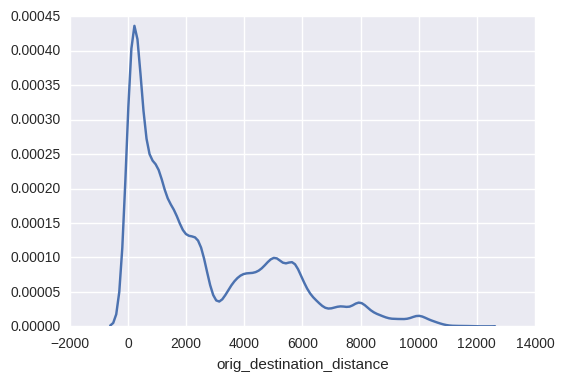

In [27]:
sns.distplot(df_sample.orig_destination_distance, hist=False)

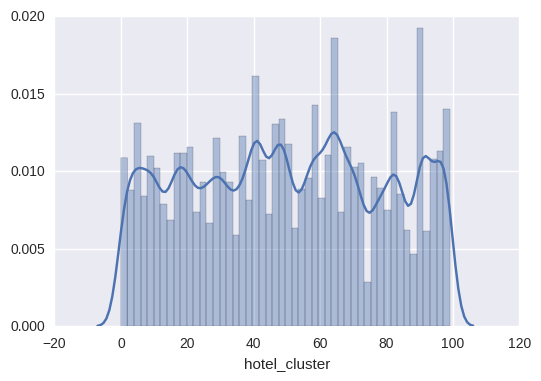

In [28]:
sns.distplot(df_sample.hotel_cluster)

In [29]:
# Save dataset to csv file to do more EDA with Tableau
df_sample.to_csv('viz_data.csv', index=False)

# Feature Selection

In [10]:
df_sample = pd.read_csv('viz_data.csv')

In [11]:
# Use random forest to select features
rf = RandomForestClassifier(n_jobs=-1)

X = df_sample.drop('hotel_cluster', axis=1)
y = df_sample.hotel_cluster

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=7)

In [124]:
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
orig_destination_distance,0.118185
user_location_city,0.112673
ci_week,0.099719
co_week,0.099011
user_location_region,0.085801
srch_destination_id,0.071738
hotel_market,0.064684
duration,0.059670
channel,0.055258
srch_adults_cnt,0.038745


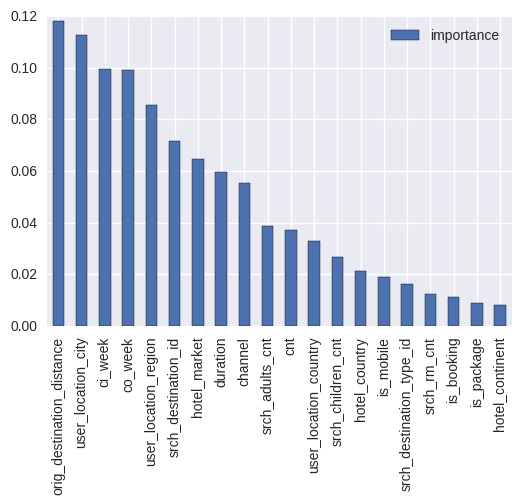

In [126]:
feature_importances.plot(kind='bar')

In [12]:
# keep features with importance higher than 0.35
X = df_sample[['user_location_city', 'co_week', 'ci_week', 'orig_destination_distance', 'user_location_region', 'duration', 
        'srch_destination_id', 'hotel_market', 'channel', 'cnt', 'srch_adults_cnt']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=7)

# Define functions to optimize, fit, and evaluate models

In [14]:
# Define a function to optimize parameters with grid search
# However, this is extremely more computationally expensive than I expect, so I end up with tuning my model manually
def gridsearch(model, params):
    gs = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print 'best parameters: ', gs.best_params_
    print 'best cross validation score on training set: ', gs.best_score_
    print 'test score: ', gs.score(X_test, y_test)
    return gs.predict(X_test), gs.predict_proba(X_test)

In [15]:
# Define function to fit models
def validation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    y_preds = y_prob.argsort(axis=1)[:,-np.arange(1,6)]
    score = model.score(X_test, y_test)
    print 'accuracy score: ', score
    return y_pred, y_prob, y_preds

In [16]:
# Define function to evaluate models
def apk(actual, predicted, k=5):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [17]:
# Transform test set to evaluate models
actual=[]
for i in y_test:
    actual.append([i])

In [18]:
# Define function to plot ROC curves
def plot_roc(model):
    y_score = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels = []
    plt.figure(figsize=[11,9])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic', fontsize=18)
    for i in range(0,3):
        hotel_type = i
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:,i], pos_label=hotel_type)
        roc_auc[i] = auc(fpr[i], tpr[i])
        labels.append(hotel_type)
        plt.plot(fpr[i], tpr[i], label='roc for {} (area={})'.format(hotel_type, roc_auc[i].round(2)), linewidth=4)
    plt.legend(loc="lower right")
    plt.show()

# Models

### Random Forest

In [41]:
# Fit the model with default parameters to see performance
rf = RandomForestClassifier(n_jobs=-1)
rf_pred, rf_prob, rf_preds = validation(rf)

accuracy score:  0.0896967361259


In [42]:
# Check the mean average precision score
mapk(actual, rf_preds)

0.14802785456091855

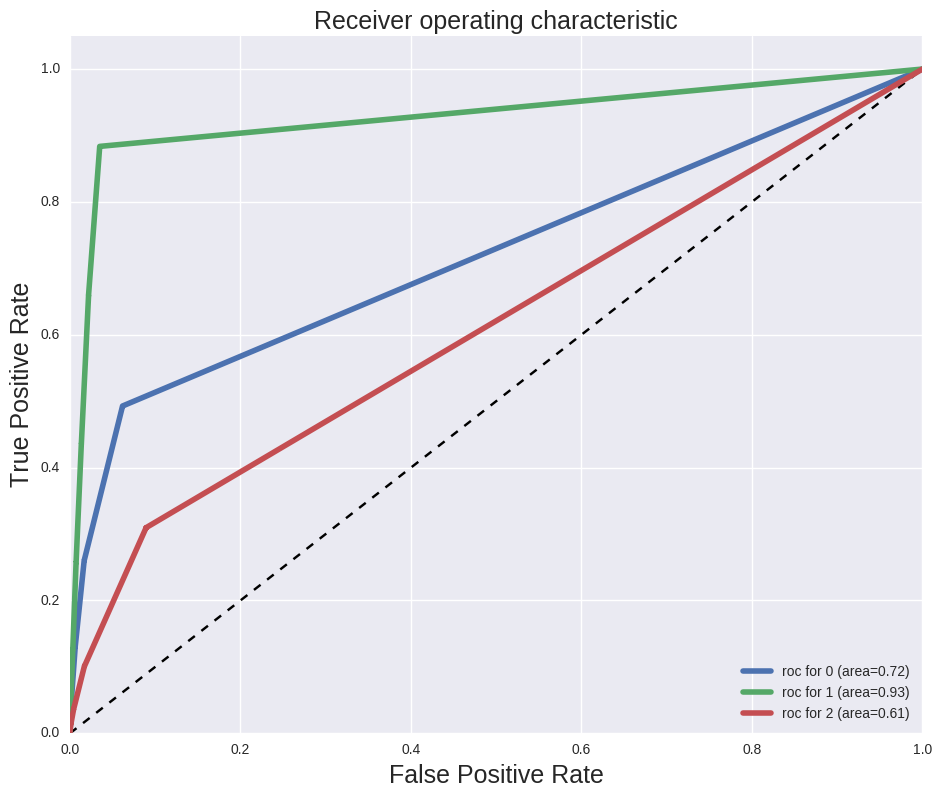

In [43]:
# Plot ROC curve for the first three classes
plot_roc(rf)

### Gradient Boosting

In [44]:
# Gradient Boosting with default parameters
gbc = GradientBoostingClassifier()
gbc_pred, gbc_prob, gbc_preds = validation(gbc)

accuracy score:  0.13699367425


In [45]:
# Much better than Random Forest
mapk(actual, gbc_preds)

0.22792986746048621

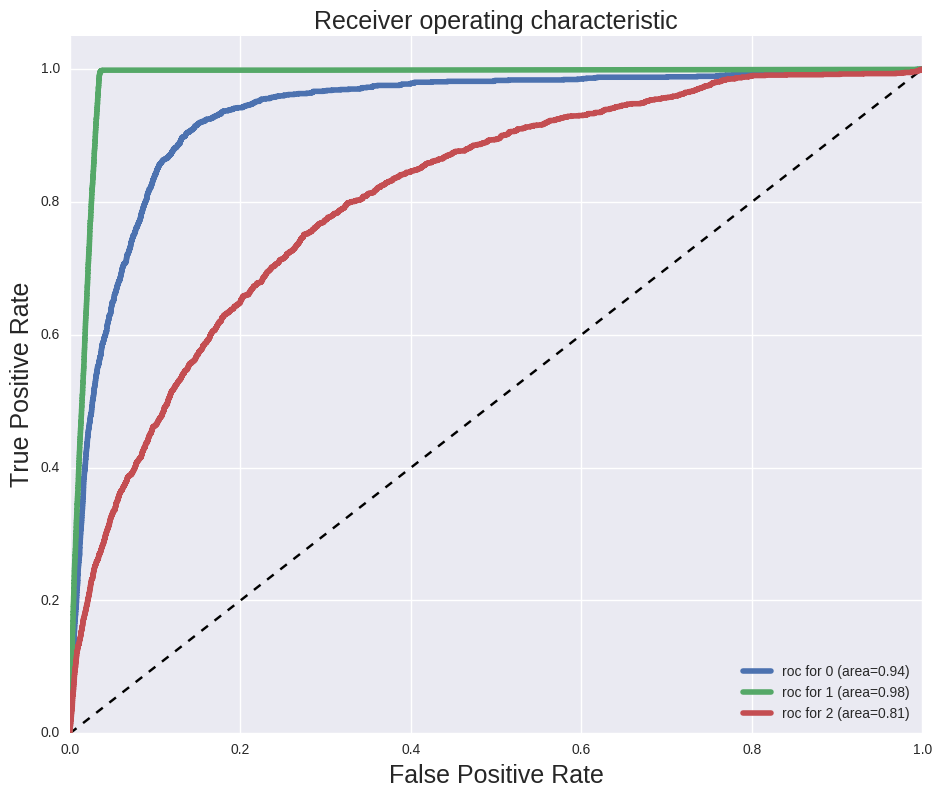

In [46]:
# Plot the ROC curve for the first three classes. Much better than Random Forest
plot_roc(gbc)

### Tuning Gradient Boosting Manually

In [48]:
# Start with tuning tree based parameters.
# Sone thumb-rules to start with: max_depth=5~8, min_samples_split=0.5%~1% rows, 
# max_features=sqrt, subsamples=0.8
# Based on the number of rows (over 370k) and features (11), try the following values first.
# Due to imbalanced data, try a relatively small number of min_sample_leaf
# To save time, just fit and check the score, without calculating prediction or probability
gbc_tune = GradientBoostingClassifier(max_depth=9, min_samples_split=1800, min_samples_leaf=200, 
                                     max_features='sqrt', subsample=0.8)
gbc_tune.fit(X_train, y_train)
gbc_tune.score(X_test, y_test)

0.13066128003402083

In [49]:
# The accuracy score is marginally lower than default setting, which indicates a slightly overfit
# as I used a higher depth. So try a value between 3 and 9 to see how it performs
gbc_tune = GradientBoostingClassifier(max_depth=7, min_samples_split=1800, min_samples_leaf=200, 
                                     max_features='sqrt', subsample=0.8)
gbc_tune.fit(X_train, y_train)
gbc_tune.score(X_test, y_test)

0.13060147778014033

In [50]:
# Again the accuracy score drop slightly, so I will keep max_depth=9. 
# There certainly are a lot more to tune, however due to time / budget constraint
# I will keep the tree based parameters as it is.
# Now try to tune boosting setting paramaters, learning rate and n_estimators
# Lower learning rate is always better given sufficient number of trees. 
# However, more trees tend to overfit and are more computationally expensive.
# Try to cut learning rate in half and increase trees proportionally.
gbc_tune = GradientBoostingClassifier(max_depth=9,min_samples_split=1800, min_samples_leaf=200, 
                                     max_features='sqrt' subsample=0.8, learning_rate=0.05, n_estimators=200)
gbc_tune.fit(X_train, y_train)
gbc_tune.score(X_test, y_test)

0.13389060174356793

In [52]:
# Accuracy score improves after tuning. Due to time / budget constraint I will not tune model any more.
# The map score dropped marginally. 
gbc_tune_prob = gbc_tune.predict_proba(X_test)
gbc_tune_preds = gbc_tune_prob.argsort(axis=1)[:,-np.arange(1,6)]
mapk(actual, gbc_tune_preds)

0.22681289425189602

### XGBoost

In [20]:
# Fit XGBoost with default parameters
xgb = XGBClassifier(objective='multi:softmax')
xgb_pred, xgb_prob, xgb_preds = validation(xgb)

accuracy score:  0.127066500106


In [21]:
# Accuracy and map score slightly lower than Gradient Boosting, but the efficiency is way much better
# (it took more than 4 hours to fit a gradient boosting model with default parameters but only 30 min to fit XGBoost)
# So I decided to tune XGBoost to see if the performence can be improved
mapk(actual, xgb_preds)

0.2131327964419874

### Tuning XGBoost manually

In [22]:
# Try to increase max_depth and tune learning_rate and n_estimators proportionally
xgb_tune = XGBClassifier(objective='multi:softmax', max_depth=9, subsample=0.8, colsample_bytree=0.8,
                    learning_rate=0.05, n_estimators=200)
xgb_tune_pred, xgb_tune_prob, xgb_tune_preds = validation(xgb_tune)

accuracy score:  0.146827822666


In [23]:
# Accuracy score and map score improve significantly and are higher than gradient boosting.
mapk(actual, xgb_tune_preds)

0.24529688496704224

In [24]:
# It took 4 hours to fit the model with max_depth=9 and 200 trees. 
# So try to fit lower depth and less tree to see if the score drops significantly
xgb2 = XGBClassifier(objective='multi:softmax', max_depth=6, colsample_bytree=0.5,
                    learning_rate=0.1, n_estimators=100)
xgb2_pred, xgb2_prob, xgb2_preds = validation(xgb2)

accuracy score:  0.144495534765


In [25]:
# The scores dropped marginally but it only took 1 hour to fit the model.
mapk(actual, xgb2_preds)

0.24156721773336165

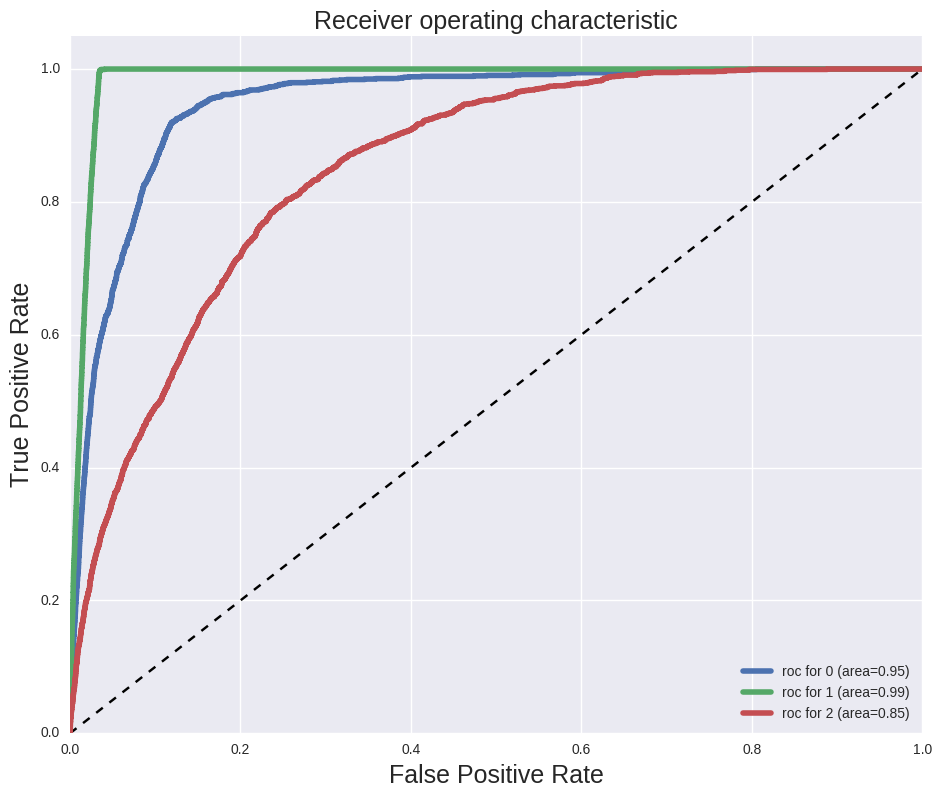

In [26]:
plot_roc(xgb2)

### Standardize features to fit non-tree based models

In [53]:
# Categorical features should have been converted into dummy variables 
# to reflect equal 'distance' between different categories
# However, the increase of dimension due to dummy variables is too computationally expensive. 
# So here I treat categorical features as numerical and standardize them.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, stratify=y, random_state=7)

### Neural Network

In [54]:
# Transform features to fit neural network
xs = X_scaled.astype(float)
ys = np_utils.to_categorical(y)

In [55]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.4, stratify=y, random_state=7)

In [56]:
xs.shape

(376232, 11)

In [57]:
ys.shape

(376232, 100)

In [112]:
# define the neural network. The parameters were tuned. Accuracy score improved from 0.05 to 0.1
def baseline_model():
    model = Sequential()
    model.add(Dense(110, input_dim=11, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(140, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(140, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [113]:
nn = KerasClassifier(build_fn=baseline_model, nb_epoch=100, batch_size=2500, verbose=0)

In [114]:
# Neural network performs worse than boosting. Probably stuck in local minima. 
# Due to time / budget constraint, I did not tune model further.
nn.fit(xs_train, ys_train)
nn.score(xs_test, ys_test)

0.10125186090962972

In [115]:
nn_pred = nn.predict(xs_test)
nn_prob = nn.predict_proba(xs_test)
nn_preds = nn_prob.argsort(axis=1)[:,-np.arange(1,6)]

In [116]:
mapk(actual, nn_preds)

0.17658830356510033

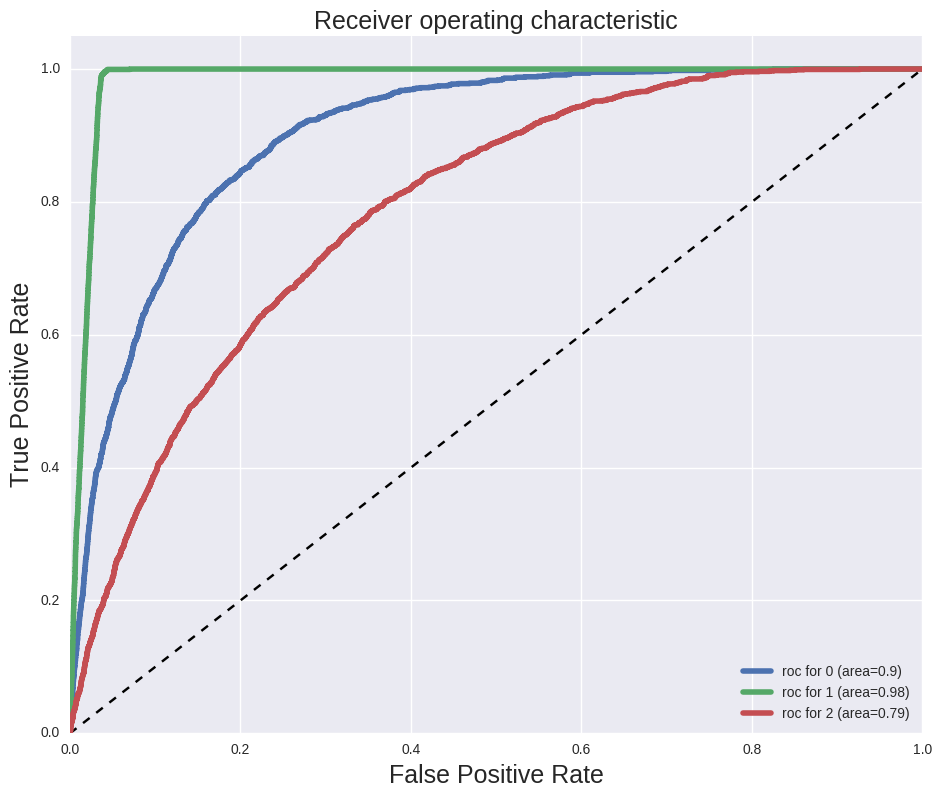

In [120]:
plot_roc(nn)

# Conclusion

Due to budget / time constraint, I did not fit model on the whole dataset. The accuracy score and mean average precision score of the best model (XGBoost) are not very impressive. A relatively small training dataset (compared to the whole dataset) and non optimized model may be the reasons. However, when dealing with big data problem, the balance of model optimization and efficiency is always the issue, so it's crutial to understand the model and the meaning of parameters and be able to tune model manually without grid search. Another interesting observation is that, when dealing with this kind of problem, boosting performs better than deep learning approach, especially when we have limited computational expense and training time.